In [37]:
from configparser import ConfigParser
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
  
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
  
    return db

In [39]:
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    result = []
    try:
        # read connection parameters
        params = config()
  
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
          
        # create a cursor
        cur = conn.cursor()
          
    # execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')
  
        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
        cur.execute("""select distinct to_char("FromDateTime", 'YYYY:MM:DD-HH24'), "StationName",
            valuespairsname, avg("Value")
            from airly."JoinAll"
            where "FromDateTime" >= '2023-03-20'
            and "AveragedValueTimeType" = 2
            group by to_char("FromDateTime", 'YYYY:MM:DD-HH24'), "StationName", valuespairsname
            order by to_char("FromDateTime", 'YYYY:MM:DD-HH24');""")
        
        measurements = cur.fetchall()
        cur.execute("""
                    select distinct "StationName", valuespairsname
                    from airly."JoinAll"
                    order by "StationName", valuespairsname;""")
        stations = cur.fetchall()
    # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    return measurements, stations

In [40]:
measurements_data, stations_data = connect()

print(len(measurements_data))
print(len(stations_data))

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 15.2 on aarch64-unknown-linux-musl, compiled by gcc (Alpine 12.2.1_git20220924-r4) 12.2.1 20220924, 64-bit',)
Database connection closed.
25400
84


In [41]:
print(measurements_data[100])
print(stations_data[0])

('2023:03:20-17', ' Rynek mogilany', 'TEMPERATURE', 10.24)
(' Miętowa, prusy', 'HUMIDITY')


In [42]:
import time
from datetime import datetime
from time import mktime

df_m = pd.DataFrame(measurements_data, columns=["Time", "Station", "Pollution", "Value"])
df_m["Time"] = df_m["Time"].apply(lambda x: pd.to_datetime(x, format="%Y:%m:%d-%H"))
df_m.head()

,Time,Station,Pollution,Value
0,2023-03-20 16:00:00,"Miętowa, prusy",HUMIDITY,71.01
1,2023-03-20 16:00:00,"Miętowa, prusy",PM1,20.49
2,2023-03-20 16:00:00,"Miętowa, prusy",PM10,45.50
3,2023-03-20 16:00:00,"Miętowa, prusy",PM25,31.98
4,2023-03-20 16:00:00,"Miętowa, prusy",PRESSURE,1014.43


In [43]:
places = df_m["Station"].value_counts()
print(places)

Franciszka Bujaka                   2429
Świętego Wawrzyńca                  2421
Emaus                               1821
 liski, szkolna                     1821
Krakowska - Zabierzów               1818
Węgrzce                             1815
 Wieliczka - Karola Kuczkiewicza    1815
 Niepołomice szkolna                1812
 Rynek mogilany                     1812
 Skała, rynek                       1812
 Miętowa, prusy                     1812
Bulwarowa                           1511
Aleja Zygmunta Krasińskiego         1208
Skawina                              907
Kaszów, no2                          586
Name: Station, dtype: int64


In [44]:
stations = df_m["Pollution"].value_counts()

print(stations)

PM10           4247
PM25           3945
PM1            3337
PRESSURE       3321
HUMIDITY       2716
TEMPERATURE    2716
NO2            2417
O3             1495
SO2             604
CO              602
Name: Pollution, dtype: int64


In [45]:
min_time = df_m["Time"].min()
print(min_time)

max_time = df_m["Time"].max()
print(max_time)

2023-03-20 16:00:00
2023-04-02 08:00:00


In [46]:
np.count_nonzero(df_m.isna().values)

0

In [47]:
df_s = pd.DataFrame(stations_data, columns=["Station", "Pollution"])
df_s.head()

,Station,Pollution
0,"Miętowa, prusy",HUMIDITY
1,"Miętowa, prusy",PM1
2,"Miętowa, prusy",PM10
3,"Miętowa, prusy",PM25
4,"Miętowa, prusy",PRESSURE


In [128]:
def create_dataset(df_m, df_s):
    df_m["Timestamp"] = df_m["Time"].apply(lambda x: int(x.timestamp()//3600))
    min_time = df_m["Timestamp"].min()
    max_time = df_m["Timestamp"].max()
    print(min_time, max_time)
    print((max_time - min_time))
    hours = int((max_time - min_time))
    data = np.full((hours, 84), np.nan)
    time = min_time
    i = 0
    while time < max_time:
        hours_data = df_m.loc[df_m["Timestamp"] == time]
        for index in range(84):
            #print(df_s)
            #print(df_s["Station"].iloc[index])
            #print(df_s["Pollution"].iloc[index])
            #print(hours_data.loc[(hours_data["Station"] == df_s["Station"].iloc[index]) & (hours_data["Pollution"] == df_s["Pollution"].iloc[index])])
            element = hours_data.loc[
                                    (hours_data["Station"] == df_s["Station"].iloc[index]) & 
                                    (hours_data["Pollution"] == df_s["Pollution"].iloc[index])]
            #print(element)
            if len(element) != 1:
                print(element, i%24, df_s["Station"].iloc[index], df_s["Pollution"].iloc[index])
            if len(element) > 0:
                data[i, index] = element["Value"].values[0]
            
        #print(time)
        time += 1
        i += 1
    
    return data 

In [129]:
data = create_dataset(df_m, df_s)
print(data.shape)

466480 466784
304
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 0 Kaszów, no2 O3
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 1 Kaszów, no2 O3
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 2 Kaszów, no2 O3
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 3 Kaszów, no2 O3
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 4 Kaszów, no2 O3
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 5 Kaszów, no2 O3
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 6 Kaszów, no2 O3
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 7 Kaszów, no2 O3
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 8 Aleja Zygmunta Krasińskiego CO
Empty DataFrame
Columns: [Time, Station, Pollution, Value, Timestamp]
Index: [] 8 Aleja Zygmu

In [130]:
np.count_nonzero(np.isnan(data))

142

In [131]:
print(data.shape)

(304, 84)


In [132]:
# print((data != np.nan).shape)

In [133]:
data[data == np.nan] = 0

In [134]:
print(data.shape)

(304, 84)


In [135]:
data[np.isnan(data)]=0
np.count_nonzero(np.isnan(data))

0

In [136]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

In [137]:
data = np.expand_dims(data, axis=1)

In [138]:
#data = np.squeeze(data, axis=-1)
print(data.shape)

(304, 1, 84)


In [139]:
import torch
from torch import nn

class ForecastModule(nn.Module):
    def __init__(self, element_size=84):
        super().__init__()
        self.lstm = nn.LSTM(84, 84)
        self.h0 = torch.zeros(1, element_size)
        self.c0 = torch.zeros(1, element_size)
        
        
    def forward(self, inputs):
        if len(inputs) == 1:
            return self.lstm(inputs[0], (self.h0, self.c0))
        else:
            return self.lstm(inputs[0], (inputs[1], inputs[2]))

In [143]:
from datetime import datetime
import torch
import numpy as np


def train_one_epoch(model, optimizer, epoch_index, trainset):
    running_loss = 0.
    last_loss = 0.
    correct = 0

    hidden = torch.zeros(1, 84)
    cell = torch.zeros(1, 84)

    for i in range(trainset.shape[0]-1):
        # Every data instance is an input + label pair
        inputs, labels = torch.tensor(trainset[i], dtype=torch.float32), torch.tensor(trainset[i+1], dtype=torch.float32)
        #print(inputs.shape)
        #print(labels.shape)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        outputs, _ = model([inputs])

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        last_loss = running_loss / (i+1)
        print('batch {} loss: {}'.format(i + 1, last_loss/(i+1)), end='\r')
    print("")

    return last_loss

In [146]:
EPOCHS = 60

trainset = data[24:-24]
valset = data[:24]
testset = data[-24:]
print(trainset.shape, valset.shape, testset.shape)

(256, 1, 84) (24, 1, 84) (24, 1, 84)


In [147]:
model = ForecastModule(84)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for i in model.parameters():
    print(i.shape)


epoch_number = 0

best_vloss = 1_000_000.
best_epoch = 0

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(model, optimizer, epoch, trainset)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0

    with torch.no_grad():
        for i in range(valset.shape[0]-1):
            vinputs, vlabels = torch.tensor(valset[i], dtype=torch.float32), torch.tensor(valset[i+1], dtype=torch.float32)
            voutputs, _ = model([vinputs])
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
        
    print('Train loss: {}, Val loss: {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_epoch = epoch
        model_path = 'model.pt'
        torch.save(model.state_dict(), model_path)

torch.Size([336, 84])
torch.Size([336, 84])
torch.Size([336])
torch.Size([336])
EPOCH 1:
batch 255 loss: 0.0031795515396740746
Train loss: 0.810785642616889, Val loss: 1.5988060235977173
EPOCH 2:
batch 255 loss: 0.0027759681737730026
Train loss: 0.7078718843121155, Val loss: 1.5887960195541382
EPOCH 3:
batch 255 loss: 0.0025615175629248764
Train loss: 0.6531869785458434, Val loss: 1.5834523439407349
EPOCH 4:
batch 255 loss: 0.0024110532772857295
Train loss: 0.6148185857078609, Val loss: 1.5294800996780396
EPOCH 5:
batch 255 loss: 0.0022843286476997814
Train loss: 0.5825038051634442, Val loss: 1.4789420366287231
EPOCH 6:
batch 255 loss: 0.0021950053666266785
Train loss: 0.5597263684898031, Val loss: 1.4423859119415283
EPOCH 7:
batch 255 loss: 0.0021326007079569394
Train loss: 0.5438131805290194, Val loss: 1.406863808631897
EPOCH 8:
batch 255 loss: 0.0020783473258520813
Train loss: 0.5299785680922807, Val loss: 1.3788186311721802
EPOCH 9:
batch 255 loss: 0.0020340634968958197
Train loss:

In [155]:
def predict(model, testset):
    model.train(False)
    outputs = []
    for i in range(testset.shape[0]):
        inputs = [torch.tensor(testset[i], dtype=torch.float32)]
        output, _ = model(inputs)
        outputs.append(output.detach().numpy())
    
    return outputs

In [156]:
outputs = predict(model, testset)

In [157]:
print(outputs)

[array([[ 0.58223677, -0.7115353 , -0.6912454 , -0.7111462 , -0.00316423,
         0.2865859 , -0.13067015, -0.7124725 , -0.7025662 , -0.70016944,
        -0.00838347,  0.4446647 ,  0.15071031, -0.7226239 , -0.73602396,
        -0.72619724, -0.0117444 ,  0.40340787,  0.46312588, -0.6126935 ,
        -0.61370224, -0.5905506 , -0.01237657,  0.26648366,  0.05219878,
        -0.73253614, -0.7242918 , -0.7278557 , -0.00544322,  0.4239434 ,
        -0.05809141, -0.7247106 , -0.715665  , -0.72068894, -0.011119  ,
         0.5199066 , -0.66094685, -0.7253132 , -0.7348678 , -0.73133624,
        -0.68072724, -0.65135014, -0.6524175 , -0.64293087,  0.46539986,
        -0.16132374,  0.5326156 , -0.7379192 , -0.7368134 , -0.7357459 ,
        -0.05801209,  0.00686686, -0.5853405 ,  0.6152162 , -0.71740574,
        -0.7250536 , -0.7082856 , -0.06404091,  0.47370434, -0.653443  ,
         0.2991743 , -0.53668267,  0.60845864, -0.72856736, -0.7336647 ,
        -0.72876394, -0.00245782, -0.6935191 , -0.

In [158]:
predictions = np.array(outputs)

In [159]:
preds = scaler.inverse_transform(predictions)
real = scaler.inverse_transform(testset)

(24, 1, 84)
(24, 1, 84)


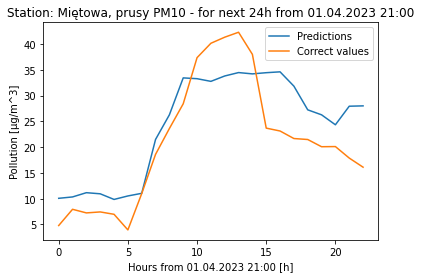

In [172]:
import matplotlib.pyplot as plt
print(preds.shape)
print(real.shape)
plt.title("Station: Miętowa, prusy PM10 - for next 24h from 01.04.2023 21:00")
plt.plot(preds[:-1, 0, 2], label="Predictions")
plt.plot(real[1:, 0, 2], label="Correct values")
plt.ylabel("Pollution [µg/m^3]")
plt.xlabel("Hours from 01.04.2023 21:00 [h]")
plt.legend()
plt.show()